Make sure you have the clips in data folder. They should be called:
- `1.MOV`
- `2.MOV`
- `3.MOV`
- `MEDIUM_1.MOV`
- `MEDIUM_2.MOV`
- `MEDIUM_3.MOV`
- `HARD_1.MOV`
- `HARD_2.MOV`
- `HARD_3.MOV`
- `test.mp4`

In [2]:
clips = [
    '1.MOV',
    '2.MOV',
    '3.MOV',
    'MEDIUM_1.MOV',
    'MEDIUM_2.MOV',
    'MEDIUM_3.MOV',
    'HARD_1.MOV',
    'HARD_2.MOV',
    'HARD_3.MOV',
    'test.mp4',
]

clips = [f'data/{clip}' for clip in clips]

In [21]:
import cv2
import numpy as np

import PIL
from PIL import Image

In [22]:
def imshow(a):
    a = a.clip(0, 255).astype("uint8")
    if a.ndim == 3:
        if a.shape[2] == 4:
            a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
        else:
            a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
    display(Image.fromarray(a))

In [5]:
def load_video(path):
    cap = cv2.VideoCapture(path)
    if cap.isOpened():
        print('Opened the file successfully.')

    print(f"File name: {path}")
    # Height and width of the video
    height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
    width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)

    print(f"Height: {height}, Width: {width}")

    # Number of frames in the video
    FPS = cap.get(cv2.CAP_PROP_FPS)
    print(f"FPS: {FPS}")

    return cap, int(height), int(width), FPS

In [5]:
test_video, test_height, test_width, test_FPS = load_video(clips[-1])

Opened the file successfully.
File name: data/test.mp4
Height: 1280.0, Width: 720.0
FPS: 25.0


In [8]:
def proper_opening(img, struct):
  transformed = cv2.morphologyEx(
      cv2.morphologyEx(
          cv2.morphologyEx(img, cv2.MORPH_CLOSE, struct), cv2.MORPH_OPEN, struct
      ), cv2.MORPH_CLOSE, struct
  )

  return np.min(np.stack((transformed, img), axis=2), axis=2)

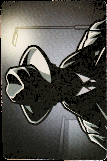

In [56]:
# pre process images used for reference
assassin = cv2.imread('data/assassin.jpg', cv2.IMREAD_COLOR)
# rotate left and downscale
assassin = cv2.resize(assassin, (176, 120))
assassin = cv2.rotate(assassin, cv2.ROTATE_90_COUNTERCLOCKWISE)
# remove background, leaving only the assassin
# find mask with the assassin

assassin_hsv = cv2.cvtColor(assassin, cv2.COLOR_BGR2HSV)
assassin_mask = cv2.inRange(assassin_hsv, (0, 0, 0), (255, 100, 255))
# apply dilation to the mask
# apply opening to the mask
assassin_mask = proper_opening(assassin_mask, np.ones((7, 7), np.uint8))

# Keep only mask remove the rest from the
new_assassin = np.zeros_like(assassin)
new_assassin[assassin_mask == 255] = assassin[assassin_mask == 255]

# crop the black background
x, y, w, h = cv2.boundingRect(assassin_mask)
assassin = new_assassin[y:y+h, x:x+w]

imshow(assassin)

In [57]:

input_file_path = clips[-1]
output_file_path = "output_video.avi"

video, height, width, FPS = load_video(input_file_path)

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*"DIVX")
output_video = cv2.VideoWriter(
    output_file_path, 
    fourcc, 
    FPS, 
    (width, height),
    )

# Create a background subtractor
fgbg = cv2.createBackgroundSubtractorMOG2()

while video.isOpened():
    ret, frame = video.read()
    if not ret:
        break

    # === Color Segmentation ===
    # Range of colors in HSV
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    # bounds for red and blue 
    lower_red = np.array([0, 100, 100])
    upper_red = np.array([12, 255, 255])
    lower_blue = np.array([98, 50, 50])
    upper_blue = np.array([118, 255, 255])

    # Threshold the HSV image to get only predefined colors
    mask_red = cv2.inRange(hsv, lower_red, upper_red)
    mask_blue = cv2.inRange(hsv, lower_blue, upper_blue)

    # Combine masks
    mask = cv2.bitwise_or(mask_red, mask_blue)
    
    # apply proper opening 
    mask = proper_opening(mask, np.ones((9, 9), np.uint8))
    # dilate mask to fill in holes
    mask = cv2.dilate(mask, np.ones((3, 3), np.uint8), iterations=3)


    # Find contours and draw bounding boxes around detected elements
    contours_red_blue, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # === Hand Detection ===

    # find background
    fgmask = fgbg.apply(frame)

    # Remove noise 
    fgmask = cv2.morphologyEx(fgmask, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)))
    fgmask = cv2.dilate(fgmask, None, iterations=2)

    contours_hand, _ = cv2.findContours(fgmask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # === Template Matching ===
    res1 = cv2.matchTemplate(frame, assassin, cv2.TM_CCOEFF_NORMED)

    # Adjust this till you get the desired threshold
    threshold = 0.7
    print(f"max value: {np.max(res1)}")
    loc1 = np.where(res1 >= threshold)

    # === Display ===
    # Display color segmentation detection results
    for contour in contours_red_blue:
        if cv2.contourArea(contour) < 1500 or cv2.contourArea(contour) > 50000:
            continue
        x, y, w, h = cv2.boundingRect(contour)

        cv2.rectangle(frame, (x,y), (x+w, y+h), (0, 255, 0), 2)
        if np.sum(mask_blue[y:y+h, x:x+w]) > np.sum(mask_red[y:y+h, x:x+w]):
            cv2.putText(frame, 'Team Blue', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
        elif np.sum(mask_blue[y:y+h, x:x+w]) < np.sum(mask_red[y:y+h, x:x+w]):
            cv2.putText(frame, 'Team Red', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)
        else:
            cv2.putText(frame, 'Assasin', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    # Display template matching detection results
    for pt in zip(*loc1[::-1]):
        cv2.rectangle(frame, pt, (pt[0] + 100, pt[1] + 100), (0, 0, 255), 2)
        cv2.putText(frame, 'Assasin', pt, cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)
    
    # Display hand detection results
    # We are assuming that hand is the biggest moving object in the frame.
    max_area = 0
    hand_box = None
    for contour in contours_hand:
        area = cv2.contourArea(contour)
        if area > max_area:
            max_area = area
            x, y, w, h = cv2.boundingRect(contour)
            hand_box = (x, y, x + w, y + h)
    
    if hand_box is not None and max_area > 50000:
        cv2.rectangle(frame, (hand_box[0], hand_box[1]), (hand_box[2], hand_box[3]), (0, 255, 0), 2)
        cv2.putText(frame, 'Picking card', (hand_box[0], hand_box[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    output_video.write(frame)

video.release()  # Release the video capture
output_video.release()

Opened the file successfully.
File name: data/test.mp4
Height: 1280.0, Width: 720.0
FPS: 25.0
max value: 0.5478911399841309
max value: 0.5475188493728638
max value: 0.5449604988098145
max value: 0.5472227334976196
max value: 0.5475387573242188
max value: 0.549136757850647
max value: 0.5500242710113525
max value: 0.5510111451148987
max value: 0.5489851236343384
max value: 0.5503764152526855
max value: 0.549148678779602
max value: 0.5496742725372314
max value: 0.5473460555076599
max value: 0.5495124459266663
max value: 0.550675630569458
max value: 0.5517069101333618
max value: 0.549780547618866
max value: 0.5497384667396545
max value: 0.5493986010551453
max value: 0.5492804050445557
max value: 0.5496556758880615
max value: 0.550144374370575
max value: 0.5499130487442017
max value: 0.5508572459220886
max value: 0.5490280985832214
max value: 0.550085723400116
max value: 0.5504404306411743
max value: 0.5496172904968262
max value: 0.5491868257522583
max value: 0.5491942763328552
max value: 0

In [ ]:
!ffmpeg -hide_banner -loglevel error -i test_red_clip.avi -y test_clip.mp4

**TODO:**
- Add filter for the hand, remove it from the color mask.
- write separate bounding box for the hand.
- fix HSV values for colors, add grey and black.
- For grey, it possible we'll need to take some pictures of the cards and compare them to the video this way.
- try to concatenate overlapping bounding boxes. [Stack Overflow](https://stackoverflow.com/questions/57258173/opencv-join-contours-when-rectangle-overlaps-another-rect)